# Поиск по изображениям

**Описание проекта**

**Клиент:** Фотохостинг для профессиональных фотографов «Со Смыслом» (“With Sense”). 
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии

**Цель**-  разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

**Юридические ограничения**
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

Необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер This image is unavailable in your country in compliance with local laws

**Описание данных**
В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.

3, 4, 5 — оценки трёх экспертов. 
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью. 

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

Ограничения:
При решении задачи используйте только один фреймворк  Pytorch или Keras.

**План проекта**

1. Загрузить данные 

2. Провести исследовательский анализ данных

3. Подготовить данные к обучению модели
- Создать список слов которые, по вашему мнению, могут попадать под юридические ограничения.
- Исключить из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения.
- Сделать векторизацию текстового описания одним из следующих методов: TF-IDF;BERT;word2vec.
- Сделать векторизацию изображений с использованием модели ResNet из библиотеки Keras или PyTorch.
- Дать описание получившихся пар векторов с точки зрения их размерностей.

4. Обучите модель
Создайте модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.
Выберите метрику, по которой вы будете сравнивать точность различных моделей.
Обучите несколько моделей и подберите их гиперпараметры. В качестве моделей обязательно нужно рассмотреть:
- Линейную регрессию;
- Полносвязные нейронные сети.

5. Тестирование модели и демонстрация ее работы
Проведите тестирование лучшей модели на тестовых данных.
Напишите функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

**Исполнение кода в тетради возможно без использования GPU за счет сохраненных в файлах эмбеддингов текстов и изображений** 

## Подготовка окружения


In [1]:
#%pip install transformers

In [2]:
#%pip show transformers

In [3]:
#%pip install optuna

In [4]:
#%pip install optuna-integration[sklearn]

In [5]:
#%pip install catboost

In [6]:
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim

import transformers
from transformers import BertTokenizer, BertModel

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import plotly.express as px
import seaborn as sns
import math
import sklearn

from tqdm import tqdm
from tqdm import notebook
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import (
    recall_score,
    mean_squared_error,
    precision_score,
    precision_recall_curve, 
    average_precision_score, 
    PrecisionRecallDisplay,
    f1_score,
    make_scorer
)

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

import requests
import zipfile
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader


import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

from sklearn.linear_model import Ridge

from catboost import CatBoostClassifier
#from catboost import CatBoostClassifier, CatBoostRegressor
                    
from lightgbm import LGBMRegressor

from sqlalchemy import create_engine
from sklearn.linear_model import Ridge

import os

import random

import pymystem3
from pymystem3 import Mystem
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')

import time 


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-12-12 21:42:43.656331: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 21:42:43.707155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 21:42:44.560225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist

In [7]:
print(sys.executable)

/usr/local/bin/python3


In [8]:
sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')

In [9]:
print(sklearn.__version__)

1.2.2


In [10]:
print(transformers.__version__)

4.47.0


In [11]:
# Создадим константы для проекта
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
pd.set_option('display.max_columns', None)

### Создание необходимых функций

In [14]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    Параметры:
    df (pandas.DataFrame): DataFrame для проверки.
    
    Выводит:
    - информацию о DataFrame,
    - количество и распределение пропущенных значений,
    - количество явных дубликатов,
    - первые пять строк DataFrame.
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())

# Для получения документации функции использовать:
#help(check_df)

In [15]:
# Функция для лемматизации
def lemmatize(text):
    # Лемматизация текста с помощью Mystem
    lemmatized_text = m.lemmatize(text)
    return ''.join(lemmatized_text)

In [16]:
# Функция для определения части речи (для улучшенной лемматизации)
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
# Функция для лемматизации текста с использованием nltk
def nltk_lemmatize(text):
    words = nltk.word_tokenize(text)  # Токенизация текста
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]  # Лемматизация с учетом части речи
    return " ".join(lemmatized_words)

In [18]:
def preprocess_text(text):
    text = text.lower()  # приведение к нижнему регистру
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # удаление ссылок
    text = re.sub(r'\@\w+|\#', '', text)  # удаление упоминаний и хештегов
    text = re.sub(r"[^a-zA-Z]", " ", text)  # удаление не букв
    return text

In [19]:
def hash_image(image):
    return hashlib.md5(image.tobytes()).hexdigest()

In [20]:
# Создадим функцию для визуализации диаграмм размаха.
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [21]:
# Создадим функцию для интерпретации стат данных.
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее
    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")
# Для получения документации функции использовать:
#help(interpret_boxplot)

Итого по разделу:

- Окружение подготовлено
- Импорты, требуемые для работы в проекте загружены
- Определены константы
- Функции, требуемые для работы в проекте созданы.

## Загрузка и знакомство с данными

https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

In [22]:
github_url_1 = 'https://github.com/fidel-1/image_search/blob/main/train_dataset.csv'
github_url_2 = 'https://github.com/fidel-1/image_search/blob/main/test_images.csv'
github_url_3 = 'https://github.com/fidel-1/image_search/blob/main/test_queries.csv'
github_url_4 = 'https://github.com/fidel-1/image_search/blob/main/CrowdAnnotations.tsv'
github_url_5 = 'https://github.com/fidel-1/image_search/blob/main/ExpertAnnotations.tsv'

In [23]:
try:
    df_train_dataset = pd.read_csv('train_dataset.csv', decimal=',')
except:
    df_kaggle_startups_train = pd.read_csv(github_url_1, decimal=',')

In [24]:
df_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [25]:
check_df(df_train_dataset)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [26]:
df_train_dataset.sample(10)

image                     query_id  \
544    542317719_ed4dd95dc2.jpg  3591458156_f1a9a33918.jpg#2   
1894  3301811927_a2797339e5.jpg  3301811927_a2797339e5.jpg#2   
5546  3516825206_5750824874.jpg  2944362789_aebbc22db4.jpg#2   
4923  2498897831_0bbb5d5b51.jpg  3677318686_b018862bb7.jpg#2   
3624  2358561039_e215a8d6cd.jpg  1287073593_f3d2a62455.jpg#2   
506   2285570521_05015cbf4b.jpg  2100816230_ff866fb352.jpg#2   
5106  2901880865_3fd7b66a45.jpg  2901880865_3fd7b66a45.jpg#2   
3805  2105756457_a100d8434e.jpg  2608289957_044849f73e.jpg#2   
408   2813992915_f732cf8539.jpg  3549583146_3e8bb2f7e9.jpg#2   
4108  2932740428_b15384f389.jpg  2891617125_f939f604c7.jpg#2   

                                             query_text  
544            A man at a rodeo is thrown off a horse .  
1894            Hockey players with one taking a shot .  
5546  A skateboarder is skating down a very steep ra...  
4923  A little boy in a purple shirt and blue shorts...  
3624               Dogs pulling a sled in a sled race .  
506                     A man jumps while snow skiing .  
5106                       A surfer is jumping a wave .  
3805  Boy in pajamas , with red and yellow toy , sea...  
408                      A young boy is riding a bike .  
4108  A person on a dirt bike is riding up a sandy h...

In [27]:
try:
    df_test_images = pd.read_csv('test_images.csv', decimal=',')
except:
    df_test_images = pd.read_csv(github_url_2, decimal=',')

In [28]:
df_test_images = pd.read_csv('test_images.csv')

In [29]:
df_test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [30]:
check_df(df_test_images)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [31]:
try:
    df_test_queries = pd.read_csv('test_queries.csv', delimiter='|')
except:
    df_test_queries = pd.read_csv(github_url_3, delimiter='|')

In [32]:
df_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [33]:
check_df(df_test_queries)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [34]:
df_test_queries=df_test_queries.drop('Unnamed: 0', axis=1)

In [35]:
df_test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [36]:
try:
    df_crowdannotations = pd.read_csv('CrowdAnnotations.tsv', delimiter='\t', header=None)
except:
    df_crowdannotations = pd.read_csv(github_url_4, delimiter='\t', header=None)

In [37]:
df_crowdannotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [38]:
df_crowdannotations.rename(
    columns={df_crowdannotations.columns[0]: "image", 
             df_crowdannotations.columns[1]: "query_id",
             df_crowdannotations.columns[2]: "ratio",
             df_crowdannotations.columns[3]: "resondents_aproved",
             df_crowdannotations.columns[4]: "resondents_nonaproved",},
    inplace=True)

In [39]:
check_df(df_crowdannotations)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  47830 non-null  object 
 1   query_id               47830 non-null  object 
 2   ratio                  47830 non-null  float64
 3   resondents_aproved     47830 non-null  int64  
 4   resondents_nonaproved  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


image                     query_id  ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2    0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2    0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2    0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2    0.0   

   resondents_aproved  resondents_nonaproved  
0                   3                      0  
1                   0                      3  
2                   0                      3  
3                   0                      3  
4                   0                      3

In [40]:
try:
    df_expertannotations = pd.read_csv('ExpertAnnotations.tsv', delimiter='\t', header=None)
except:
    df_expertannotations = pd.read_csv(github_url_5, delimiter='\t', header=None)

In [41]:
df_expertannotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [42]:
df_expertannotations.rename(
    columns={df_expertannotations.columns[0]: "image", 
             df_expertannotations.columns[1]: "query_id",
             df_expertannotations.columns[2]: "expert_1",
             df_expertannotations.columns[3]: "expert_2",
             df_expertannotations.columns[4]: "expert_3",
            },
    inplace=True)

In [43]:
check_df(df_expertannotations)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [44]:
df_expertannotations.sample(5)

image                     query_id  expert_1  \
5165   424416723_19c56cb365.jpg  3564312955_716e86c48b.jpg#2         1   
4276  3485425825_c2f3446e73.jpg  1287073593_f3d2a62455.jpg#2         1   
119   1258913059_07c613f7ff.jpg  3729525173_7f984ed776.jpg#2         1   
4820  3640422448_a0f42e4559.jpg  3462454965_a481809cea.jpg#2         1   
3561  3250695024_93e8ab7305.jpg  2086513494_dbbcb583e7.jpg#2         2   

      expert_2  expert_3  
5165         1         1  
4276         1         1  
119          2         2  
4820         1         1  
3561         2         2

In [45]:
# URL к архиву
url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

# Скачиваем архив в память
response = requests.get(url)
zip_bytes = BytesIO(response.content)
zip_file = zipfile.ZipFile(zip_bytes, 'r')

# Фильтруем список файлов, оставляя только изображения из каталога test_images
file_list = [name for name in zip_file.namelist() 
             if name.startswith("to_upload/test_images/") and name.endswith('.jpg')]

class ZipImageDataset(Dataset):
    def __init__(self, zip_file, file_names, transform=None):
        self.zip_file = zip_file
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = self.file_names[idx]
        img_data = self.zip_file.read(img_name)
        image = Image.open(BytesIO(img_data)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


In [46]:
# Определяем трансформации для изображений 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Создаем датасет и даталоудер
dataset = ZipImageDataset(zip_file, file_list, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [47]:
# Теперь будем итерироваться по dataloader и получать батчи изображений:
for batch in dataloader:
    # batch будет содержать тензоры изображений
    print(batch.size())
    
    break

torch.Size([32, 3, 224, 224])


In [48]:
# Получаем первый батч
batch = next(iter(dataloader))
images = batch[0][:10]  #  batch[0] — это тензор с изображениями если я правильно понимаю


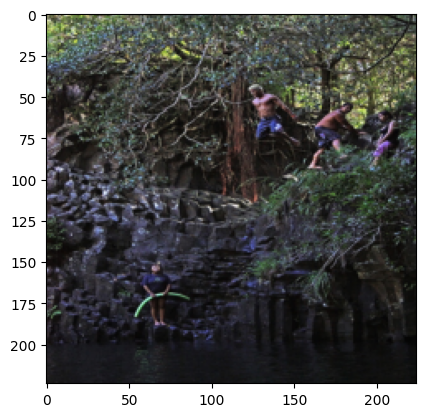

In [49]:
img = images.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

Итого по разделу:
Данные загружены, признаки и форматы соответствуют описанию

## EDA

In [50]:
df_train_dataset.image.nunique()

1000

Количество названий изображений совпадает с количеством изображений в папке train_images

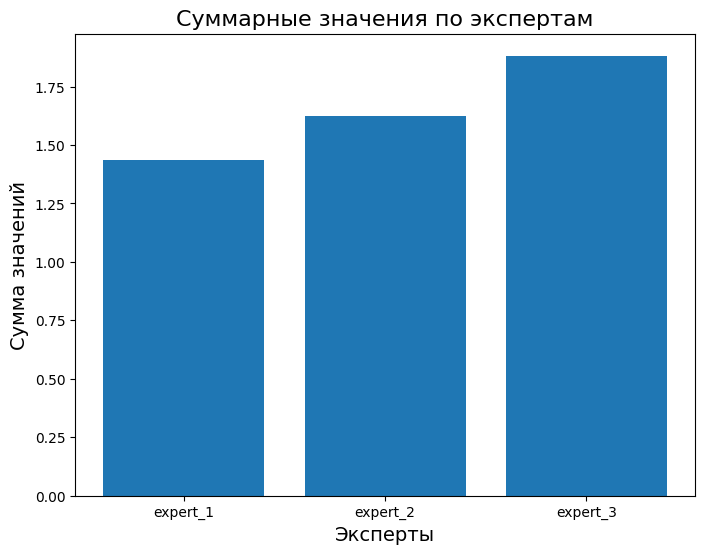

In [51]:
# Средние значения по каждому столбцу
expert_mean = df_expertannotations[['expert_1', 'expert_2', 'expert_3']].mean()

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 6))
plt.bar(expert_mean.index, expert_mean.values)

# Добавляем подписи
plt.title("Суммарные значения по экспертам", fontsize=16)
plt.xlabel("Эксперты", fontsize=14)
plt.ylabel("Сумма значений", fontsize=14)

# Показать график
plt.show()

Наблюдаем что в среднем эксперт_3 более слонен к проставлению высоких оценок соответствия, в отличии от эксперта_1. 
Можно посмотреть детальнее каждого эксперта. Но в целом  критической разницы в оценках не наблюдается и ожидаю, что коэффициентов к оценкам вводить не потребуется.

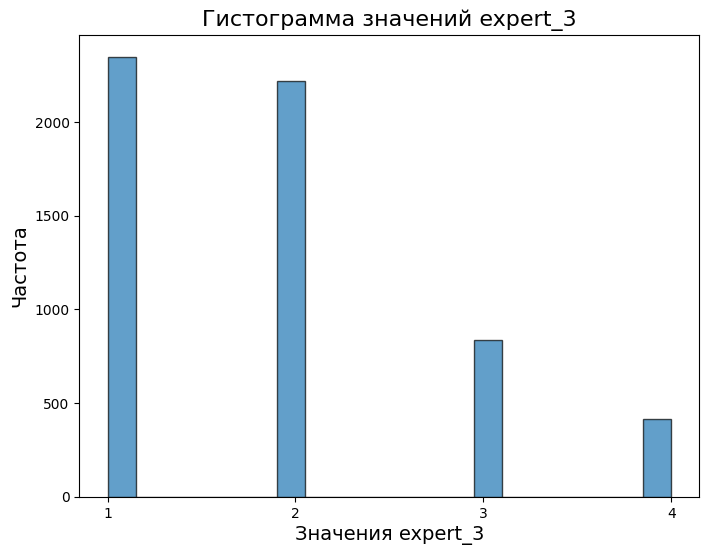

In [52]:

# Построение гистограммы для expert_3
plt.figure(figsize=(8, 6))
plt.hist(df_expertannotations['expert_3'], bins=20, edgecolor='black', alpha=0.7)

# Добавляем подписи
plt.title("Гистограмма значений expert_3", fontsize=16)
plt.xlabel("Значения expert_3", fontsize=14)
plt.ylabel("Частота", fontsize=14)

# Оставляем только целые значения на оси X
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Показать график
plt.show()

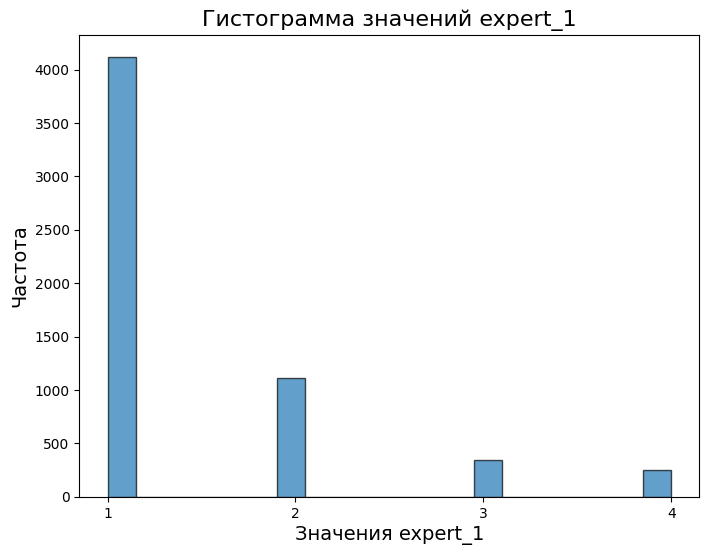

In [53]:
from matplotlib.ticker import MaxNLocator
# Построение гистограммы для expert_3
plt.figure(figsize=(8, 6))
plt.hist(df_expertannotations['expert_1'], bins=20, edgecolor='black', alpha=0.7)

# Добавляем подписи
plt.title("Гистограмма значений expert_1", fontsize=16)
plt.xlabel("Значения expert_1", fontsize=14)
plt.ylabel("Частота", fontsize=14)

# Оставляем только целые значения на оси X
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Показать график
plt.show()

In [54]:
#  присоединим df_crowdannotations к df_train_dataset
df_train_full = df_train_dataset.merge(
    df_crowdannotations,
    on=['image', 'query_id'],
    how='inner'  
)

#  присоединим df_expertannotations к df_train_full
df_train_full = df_train_full.merge(
    df_expertannotations,
    on=['image', 'query_id'],
    how='inner'  
)

In [55]:
df_train_full.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  ratio  \
0  A young child is wearing blue goggles and sitt...    0.0   
1  A young child is wearing blue goggles and sitt...    0.0   
2  A young child is wearing blue goggles and sitt...    1.0   
3  A young child is wearing blue goggles and sitt...    0.0   
4  A young child is wearing blue goggles and sitt...    0.0   

   resondents_aproved  resondents_nonaproved  expert_1  expert_2  expert_3  
0                   0                      3         1         1         1  
1                   0                      3         1         2         2  
2                   3                      0         4         4         4  
3                   0                      3         2         2         3  
4                   0                      3         1         1         1

In [56]:
df_train_full.image.nunique()

891

Проведем визуальную проверку работы экспертов

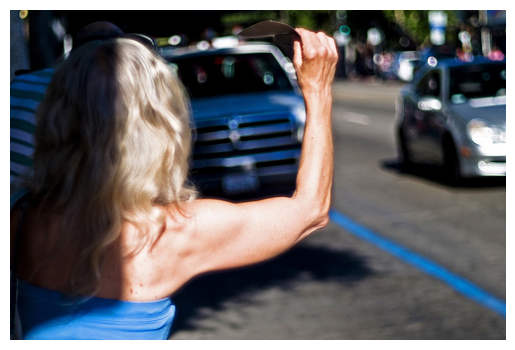

In [57]:

# URL архива
url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"

# Скачиваем архив в память
response = requests.get(url)
zip_bytes = BytesIO(response.content)

# Открываем архив как zip-файл
zip_file = zipfile.ZipFile(zip_bytes, 'r')

# Читаем  изображение из архива
img_data = zip_file.read("to_upload/train_images/1056338697_4f7d7ce270.jpg")

# Превращаем байты в изображение PIL
img = Image.open(BytesIO(img_data)).convert('RGB')

# Отображаем изображение
plt.imshow(img)
plt.axis('off')
plt.show()

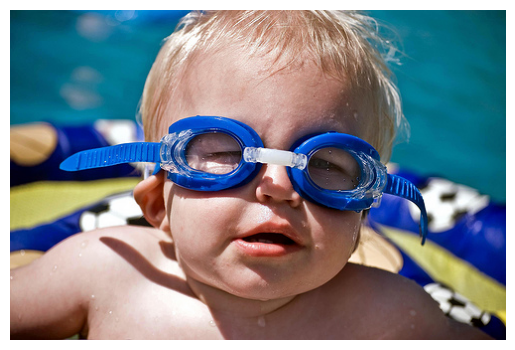

In [111]:
# Читаем  изображение из архива
img_data = zip_file.read("to_upload/train_images/2549968784_39bfbe44f9.jpg")

# Превращаем байты в изображение PIL
img = Image.open(BytesIO(img_data)).convert('RGB')

# Отображаем изображение
plt.imshow(img)
plt.axis('off')
plt.show()

Качество работы экспертов на достаточном уровне. При создании финального скора будем присваивать им вес 0,6

In [59]:
# Добавляем новый столбец с итоговой вероятностью соответствия изображения и описания
df_train_full['final_prob'] = round(df_train_full['ratio'] * 0.6 + ((df_train_full['expert_1'] + df_train_full['expert_2'] + df_train_full['expert_3']) / 12)*0.4, 4)


In [60]:
df_train_full.sample(10)

image                     query_id  \
749    143688283_a96ded20f1.jpg  3320356356_1497e53f80.jpg#2   
2056  3485425825_c2f3446e73.jpg  1356796100_b265479721.jpg#2   
1115  3498327617_d2e3db3ee3.jpg  1772859261_236c09b861.jpg#2   
995   2084217208_7bd9bc85e5.jpg  2084217208_7bd9bc85e5.jpg#2   
1542  3259991972_fce3ab18b2.jpg  3425835357_204e620a66.jpg#2   
1516  3498997518_c2b16f0a0e.jpg  3498997518_c2b16f0a0e.jpg#2   
1310  3028969146_26929ae0e8.jpg  2696866120_254a0345bc.jpg#2   
1344   180094434_b0f244832d.jpg   421730441_6b2267fd31.jpg#2   
1023  3015863181_92ff43f4d8.jpg  1467533293_a2656cc000.jpg#2   
242    542317719_ed4dd95dc2.jpg  2594042571_2e4666507e.jpg#2   

                                             query_text     ratio  \
749                 A man scales a rock in the forest .  0.666667   
2056            a girl peeks through the green leaves .  0.000000   
1115                 A dog splashes through the water .  1.000000   
995                     A woman riding a bike in a park  1.000000   
1542  A man is standing on his hands on a sidewalk w...  0.666667   
1516  A football player is tackling the player with ...  1.000000   
1310                        A dog rolls on the ground .  0.333333   
1344      A man standing in front of a brick building .  0.000000   
1023  Two little girls , both dressed in pink , play...  0.000000   
242   A smiling boy in an orange shirt with a safari...  0.000000   

      resondents_aproved  resondents_nonaproved  expert_1  expert_2  expert_3  \
749                    2                      1         4         4         4   
2056                   0                      3         2         2         2   
1115                   3                      0         4         4         4   
995                    3                      0         4         4         4   
1542                   2                      1         4         4         4   
1516                   3                      0         3         4         4   
1310                   1                      2         2         2         2   
1344                   0                      3         1         2         2   
1023                   0                      3         1         1         1   
242                    0                      3         2         2         2   

      final_prob  
749       0.8000  
2056      0.2000  
1115      1.0000  
995       1.0000  
1542      0.8000  
1516      0.9667  
1310      0.4000  
1344      0.1667  
1023      0.1000  
242       0.2000

### Проверка данных на наличие запрещенного контента

In [61]:
# Определяем регулярное выражение для поиска описаний о детях младше 16
pattern = r'\b(child|children|boy|girl|baby|kid|infant|teen|(?:\bage(?:d)?\s?(?:[1-9]|1[0-6]))|(?:\b(?:[1-9]|1[0-6])\s?years? old))'

# Соберем строки, которые будут удалены
deleted_rows = df_train_full[df_train_full['query_text'].str.contains(pattern, case=False, na=False)]

# Фильтруем датафрейм: удаляем строки с запрещенным контентом 
df_train_full_filtered = df_train_full[~df_train_full['query_text'].str.contains(pattern, case=False, na=False)]


In [62]:
df_train_full_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 12 to 2328
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  1800 non-null   object 
 1   query_id               1800 non-null   object 
 2   query_text             1800 non-null   object 
 3   ratio                  1800 non-null   float64
 4   resondents_aproved     1800 non-null   int64  
 5   resondents_nonaproved  1800 non-null   int64  
 6   expert_1               1800 non-null   int64  
 7   expert_2               1800 non-null   int64  
 8   expert_3               1800 non-null   int64  
 9   final_prob             1800 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 154.7+ KB


In [63]:
df_train_full_filtered.sample(5)

image                     query_id  \
676    317109978_cb557802e1.jpg   317109978_cb557802e1.jpg#2   
1925  3223224391_be50bf4f43.jpg  3197917064_e679a44b8e.jpg#2   
1880   302983277_69a4e732e4.jpg    57422853_b5f6366081.jpg#2   
823   1517721825_10176d0683.jpg  2938747424_64e64784f0.jpg#2   
1454  2926595608_69b22be8d4.jpg  3017521547_f5ef8848e3.jpg#2   

                                             query_text     ratio  \
676        A brown dog hops over a fallen tree branch .  1.000000   
1925  A white dog in the snow running with an object...  0.000000   
1880             A man sits in his tent on a mountain .  0.000000   
823   A white dog is running through the water onto ...  0.333333   
1454  Two women are playing a game with sticks and a...  0.000000   

      resondents_aproved  resondents_nonaproved  expert_1  expert_2  expert_3  \
676                    3                      0         4         4         4   
1925                   0                      3         3         3         3   
1880                   0                      3         2         2         2   
823                    1                      2         3         3         3   
1454                   0                      3         1         2         2   

      final_prob  
676       1.0000  
1925      0.3000  
1880      0.2000  
823       0.5000  
1454      0.1667

In [64]:
deleted_rows.head(5)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  ratio  \
0  A young child is wearing blue goggles and sitt...    0.0   
1  A young child is wearing blue goggles and sitt...    0.0   
2  A young child is wearing blue goggles and sitt...    1.0   
3  A young child is wearing blue goggles and sitt...    0.0   
4  A young child is wearing blue goggles and sitt...    0.0   

   resondents_aproved  resondents_nonaproved  expert_1  expert_2  expert_3  \
0                   0                      3         1         1         1   
1                   0                      3         1         2         2   
2                   3                      0         4         4         4   
3                   0                      3         2         2         3   
4                   0                      3         1         1         1   

   final_prob  
0      0.1000  
1      0.1667  
2      1.0000  
3      0.2333  
4      0.1000

In [65]:
check_df(df_train_full_filtered)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 12 to 2328
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  1800 non-null   object 
 1   query_id               1800 non-null   object 
 2   query_text             1800 non-null   object 
 3   ratio                  1800 non-null   float64
 4   resondents_aproved     1800 non-null   int64  
 5   resondents_nonaproved  1800 non-null   int64  
 6   expert_1               1800 non-null   int64  
 7   expert_2               1800 non-null   int64  
 8   expert_3               1800 non-null   int64  
 9   final_prob             1800 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 154.7+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


image                     query_id  \
12   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
13   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
14  1962729184_6996e128e7.jpg  3286822339_5535af6b93.jpg#2   
15  2101457132_69c950bc45.jpg  3286822339_5535af6b93.jpg#2   
16  2351479551_e8820a1ff3.jpg  3360930596_1e75164ce6.jpg#2   

                                           query_text  ratio  \
12    A man sleeps under a blanket on a city street .    0.0   
13  A woman plays with long red ribbons in an empt...    0.0   
14         Chinese market street in the winter time .    0.0   
15         Chinese market street in the winter time .    0.0   
16  A soccer ball is above the head of a man weari...    0.0   

    resondents_aproved  resondents_nonaproved  expert_1  expert_2  expert_3  \
12                   0                      3         2         2         2   
13                   0                      5         1         1         1   
14                   0                      3         1         2         3   
15                   0                      3         1         1         1   
16                   0                      3         1         1         2   

    final_prob  
12      0.2000  
13      0.1000  
14      0.2000  
15      0.1000  
16      0.1333

In [66]:
df_train_full_filtered.query_id.nunique()

557

In [67]:
df_train_full_filtered.image.nunique()

773

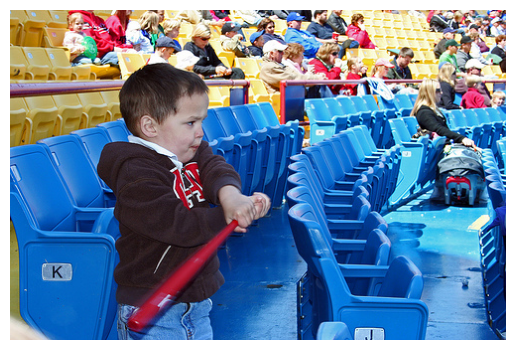

In [68]:
# Читаем  изображение из архива
img_data = zip_file.read("to_upload/train_images/2447284966_d6bbdb4b6e.jpg")

# Превращаем байты в изображение PIL
img = Image.open(BytesIO(img_data)).convert('RGB')

# Отображаем изображение
plt.imshow(img)
plt.axis('off')
plt.show()

Визуально фильтр работает

**Итоги раздела:**
- Проведен анализ оценок экспертов.Значительных отклонений в оценках эспертов не обраружено.
- Оценки экспертов и пользователей краудсорсинга обьеденены и приведены к единому значению. 
- Удалены записи с описанием, содержащим запрещенный контент.
- Расчитан финальный скорр учитывающий оценки экспертов (больше доверия) и разметчиков краутсорсинга (меньше доверия).
- Наблюдаем также неуникальность ключей image и query_id. Объединения датафреймов проводились по сумме ключей

## Векторизация изображений

In [69]:
# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:

# Загружаем предобученную сеть ResNet18
resnet = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.8MB/s]


In [71]:

# Перемещаем модель на GPU
resnet = resnet.to(device)


In [72]:

# Посмотрим архитектуру модели
summary(resnet, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [73]:
# Проверяем наличие сохранённых эмбеддингов
if os.path.exists("image_embeddings.pt") and os.path.exists("file_names.txt"):
    print("Эмбеддинги изображений уже существуют. Загружаем данные...")
    embeddings = torch.load("image_embeddings.pt")
    with open("file_names.txt", "r") as f:
        file_names = f.read().splitlines()
    print(f"Загружены эмбеддинги для {len(file_names)} изображений.")
else:
    print("Эмбеддинги не найдены. Генерируем заново...")

    # Удаляем последний слой у ResNet18
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)

    # Оборачиваем ResNet в класс для получения эмбеддингов
    class ResNetWithEmbeddings(nn.Module):
        def __init__(self, base_model):
            super().__init__()
            self.base = base_model

        def forward(self, x):
            x = self.base(x)  # Получаем выход до AdaptiveAvgPool2d
            x = x.view(x.size(0), -1)  # Преобразуем [batch_size, 512, 1, 1] в [batch_size, 512]
            return x

    resnet_embeddings = ResNetWithEmbeddings(resnet).to(device)
    resnet_embeddings.eval()  # Переводим в режим предсказания

    # Создаём класс для загрузки изображений
    class ImageDataset(Dataset):
        def __init__(self, image_dir, transform=None):
            self.image_dir = image_dir
            self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
            self.transform = transform

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.image_files[idx]

    # Нормализуем изображения
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Изменяем размер изображения для ResNet18
        transforms.ToTensor(),         # Преобразуем в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация, как для ImageNet
    ])

    # Создаём датасет и DataLoader
    image_dir = "train_images"
    dataset = ImageDataset(image_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

    # Генерация эмбеддингов
    embeddings = []
    file_names = []

    with torch.no_grad():  # Отключаем градиенты для ускорения
        for images, names in tqdm(dataloader, desc="Генерация эмбеддингов"):
            images = images.to(device)
            embs = resnet_embeddings(images)  # Формируем эмбеддинги
            embeddings.append(embs.cpu())    # Переносим эмбеддинги на CPU
            file_names.extend(names)         # Сохраняем имена файлов

    # Объединяем эмбеддинги в один тензор
    embeddings = torch.cat(embeddings, dim=0)

    # Сохраняем эмбеддинги и имена файлов
    torch.save(embeddings, "image_embeddings.pt")  # Сохраняем эмбеддинги в файл
    with open("file_names.txt", "w") as f:
        for name in file_names:
            f.write(name + "\n")

    print(f"Эмбеддинги сформированы и сохранены. Всего изображений: {len(file_names)}")

Эмбеддинги изображений уже существуют. Загружаем данные...
Загружены эмбеддинги для 1000 изображений.


In [74]:
df_train_full_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1800 entries, 12 to 2328
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  1800 non-null   object 
 1   query_id               1800 non-null   object 
 2   query_text             1800 non-null   object 
 3   ratio                  1800 non-null   float64
 4   resondents_aproved     1800 non-null   int64  
 5   resondents_nonaproved  1800 non-null   int64  
 6   expert_1               1800 non-null   int64  
 7   expert_2               1800 non-null   int64  
 8   expert_3               1800 non-null   int64  
 9   final_prob             1800 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 154.7+ KB


**Итого по разделу:**
- Расчитаны эмбеддинги изображений тренировочных данных с использованием предобученной REZNET18 "без головы".
- Эмбеддинги сохранены в файл с ключом image

## Векторизация текстов

In [75]:
# Проверяем, существует ли сохранённый файл с эмбеддингами
if os.path.exists('bert_features.npz'):
    # Загружаем эмбеддинги из файла
    bert_data = np.load('bert_features.npz', allow_pickle=True)
    features = bert_data['features']
    query_ids = bert_data['query_ids']
    
    # Оставим только уникальные query_ids 
    query_ids = np.unique(query_ids)
    
    # Удостоверяемся, что данные согласованы по query_id
    df_train_full_filtered = df_train_full_filtered[df_train_full_filtered['query_id'].isin(query_ids)]
    
    # Обеспечиваем порядок query_id
    df_train_full_filtered = df_train_full_filtered.set_index('query_id').loc[query_ids].reset_index()
    print(f"Загружены эмбеддинги для {len(features)} текстов.")
else:
    # Инициализация токенизатора BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Токенизация текстовых описаний
    tokenized = df_train_full_filtered['query_text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

    # Определяем максимальную длину токенов
    max_len = max(len(i) for i in tokenized.values)

    # Применяем padding к токенам
    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    # Создаём маску внимания
    attention_mask = np.where(padded != 0, 1, 0)

    # Загружаем предобученную модель BERT и перемещаем её на GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertModel.from_pretrained('bert-base-uncased').to(device)

    # Вычисляем эмбеддинги батчами
    batch_size = 100
    embeddings = []
    padded = torch.LongTensor(padded).to(device)
    attention_mask = torch.LongTensor(attention_mask).to(device)

    for i in tqdm(range((padded.shape[0] + batch_size - 1) // batch_size), desc="Генерация эмбеддингов"):
        # Формируем батч
        batch = padded[batch_size * i: batch_size * (i + 1)]
        attention_mask_batch = attention_mask[batch_size * i: batch_size * (i + 1)]

        # Вычисляем эмбеддинги
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # Извлекаем эмбеддинги для [CLS]-токена
        embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    # Объединяем эмбеддинги в один массив
    features = np.concatenate(embeddings, axis=0)

    # Сохраняем эмбеддинги и query_id
    np.savez('bert_features.npz', features=features, query_ids=df_train_full_filtered['query_id'].values)
    print(f"Эмбеддинги текстов сохранены.")

Загружены эмбеддинги для 1800 текстов.


In [76]:
df_train_full_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   query_id               1800 non-null   object 
 1   image                  1800 non-null   object 
 2   query_text             1800 non-null   object 
 3   ratio                  1800 non-null   float64
 4   resondents_aproved     1800 non-null   int64  
 5   resondents_nonaproved  1800 non-null   int64  
 6   expert_1               1800 non-null   int64  
 7   expert_2               1800 non-null   int64  
 8   expert_3               1800 non-null   int64  
 9   final_prob             1800 non-null   float64
dtypes: float64(2), int64(5), object(3)
memory usage: 140.8+ KB


In [77]:
df_train_full_filtered.query_id.nunique()

557

**Итого по разделу:**
- Расчитаны эмбеддинги текстов тренировочных данных с использованием BERT
- Эмбеддинги сохранены в файл с ключом query_id

## Подготовка данных. Объединение векторов и целевой переменной

In [78]:
#  Удаление дублей в эмбеддингах изображений
image_embeddings = torch.load("image_embeddings.pt")
with open("file_names.txt", "r") as f:
    image_file_names = f.read().splitlines()

unique_image_file_names, unique_image_indices = np.unique(image_file_names, return_index=True)
image_embeddings = image_embeddings[unique_image_indices]
image_file_names = list(unique_image_file_names)

#  Удаление дублей в эмбеддингах текстов
bert_data = np.load("bert_features.npz", allow_pickle=True)
text_embeddings = bert_data['features']
query_ids_text = bert_data['query_ids']

unique_query_ids, unique_text_indices = np.unique(query_ids_text, return_index=True)
text_embeddings = text_embeddings[unique_text_indices]
query_ids_text = list(unique_query_ids)

# Сопоставление эмбеддингов изображений
image_to_index = {name: idx for idx, name in enumerate(image_file_names)}
image_indices = [image_to_index[img] for img in df_train_full_filtered['image']]
filtered_image_embeddings = image_embeddings[image_indices].numpy()

#  Сопоставление эмбеддингов текстов
query_to_index = {query_id: idx for idx, query_id in enumerate(query_ids_text)}
text_indices = [query_to_index[qid] for qid in df_train_full_filtered['query_id']]
filtered_text_embeddings = text_embeddings[text_indices]

#  Объединение эмбеддингов
combined_features = np.hstack([filtered_image_embeddings, filtered_text_embeddings])

#  Добавление целевой переменной
target = df_train_full_filtered['final_prob'].values

# Проверяем соответствие размеров
assert combined_features.shape[0] == target.shape[0], "Размеры признаков и целевой переменной не совпадают"



print(f"Данные  объединены. Размер признаков: {combined_features.shape}, Целевая переменная: {target.shape}")


Данные  объединены. Размер признаков: (1800, 1280), Целевая переменная: (1800,)


In [79]:
print("Уникальные изображения в df_train_full_filtered:", df_train_full_filtered['image'].nunique())
print("Уникальные query_id в df_train_full_filtered:", df_train_full_filtered['query_id'].nunique())

print("Общее количество изображений в file_names:", len(set(image_file_names)))
print("Общее количество query_id в bert_features:", len(set(query_ids_text)))

Уникальные изображения в df_train_full_filtered: 773
Уникальные query_id в df_train_full_filtered: 557
Общее количество изображений в file_names: 1000
Общее количество query_id в bert_features: 557


In [80]:
combined_features

array([[ 0.37794673,  1.567589  ,  0.70993304, ..., -0.23006168,
         0.05157362, -0.149235  ],
       [ 0.8515812 ,  0.47584978,  0.29368317, ..., -0.03914349,
         0.51922077,  0.3428385 ],
       [ 0.11516765,  0.24136956,  2.2488468 , ..., -0.17264228,
         0.3769405 ,  0.4248726 ],
       ...,
       [ 0.43916085,  0.00973913,  0.00394689, ..., -0.29379615,
         0.19377434,  0.19434063],
       [ 1.7102805 ,  0.3894296 ,  0.35793304, ..., -0.03226974,
         0.09774835,  0.44081208],
       [ 0.29052845,  0.07341328,  0.56442434, ..., -0.17460912,
         0.283018  , -0.03104078]], dtype=float32)

In [81]:
# Проверка на наличие NaN
contains_nan = np.isnan(combined_features).any()
print(f"Содержатся ли NaN значения в combined_features: {contains_nan}")

# Проверка на наличие Inf или -Inf
contains_inf = np.isinf(combined_features).any()
print(f"Содержатся ли Inf значения в combined_features: {contains_inf}")

# Итоговая проверка на отсутствие некорректных данных
if contains_nan or contains_inf:
    print("В массиве combined_features есть некорректные значения")
else:
    print("Все значения в массиве combined_features корректны.")

Содержатся ли NaN значения в combined_features: False
Содержатся ли Inf значения в combined_features: False
Все значения в массиве combined_features корректны.


**Итого по разделу:**

Данные подготовлены, вектора текстов и изображений объединены в единый вектор размерностью 1280.
Данные сохранены с целевым признаком в переменные combined_features и target .


## Обучение модели предсказания соответствия

Исходя из того что нам нужно подобрать под описание изображение с максимальными скором, который принимает непрерывные значения от 0 до 1, то мы решаем задачу регрессии и выберем метрикой качества RMSE 

In [82]:
 #Разобъем данные на тренировочную и тестовую выборки согласно условию проекта
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)

# Используем 'image' в качестве групп для разбиения
train_indices, test_indices = next(gss.split(X=combined_features, y=target, groups=df_train_full_filtered['image']))

X_train, X_test = combined_features[train_indices], combined_features[test_indices]
y_train, y_test = target[train_indices], target[test_indices]

print(f"Тренировочная выборка: {len(X_train)} записей, тестовая выборка: {len(X_test)} записей.")

Тренировочная выборка: 1288 записей, тестовая выборка: 512 записей.


### Обучим base-line модель

In [83]:
# Инициализация модели линейной регрессии
lr = LinearRegression()

# Кросс-валидация с метрикой RMSE на тренировочном наборе
cv_scores = cross_val_score(
    lr, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_root_mean_squared_error'  # Используем отрицательный RMSE, так как sklearn возвращает отрицательные значения для метрик потерь
)

# Средний RMSE по фолдам
mean_rmse = -np.mean(cv_scores)  # Убираем знак минуса, чтобы получить положительное значение
std_rmse = np.std(cv_scores)
print(f"Средний RMSE по фолдам (тренировочная выборка): {mean_rmse:.4f} ± {std_rmse:.4f}")

Средний RMSE по фолдам (тренировочная выборка): 9.1296 ± 16.5486


### Обучим ridge с подбором гипперпараметров

In [84]:

# Инициализация модели 
ridge = Ridge()

# Собереме гиперпараметры для поиска
param_distributions = {
    'alpha': optuna.distributions.FloatDistribution(0.01, 10.0)  # Диапазон регуляризации
}

# Инициализация OptunaSearchCV
optuna_search = OptunaSearchCV(
    estimator=ridge,
    param_distributions=param_distributions,
    cv=5,  # Кросс-валидация
    scoring='neg_root_mean_squared_error',  # Оптимизация по RMSE
    n_trials=20,  # Количество попыток для Optuna
    random_state=RANDOM_STATE,
    n_jobs=-1  # Параллельное выполнение
)


In [85]:

# Обучаем
optuna_search.fit(X_train, y_train)

[I 2024-12-12 21:43:00,482] A new study created in memory with name: no-name-1a5481c0-19e0-46b0-b9e0-56b513a16f77
[I 2024-12-12 21:43:01,153] Trial 2 finished with value: -0.3380459255579873 and parameters: {'alpha': 8.196559652389046}. Best is trial 2 with value: -0.3380459255579873.
[I 2024-12-12 21:43:01,258] Trial 0 finished with value: -0.3372809101799312 and parameters: {'alpha': 8.426011295379999}. Best is trial 0 with value: -0.3372809101799312.
[I 2024-12-12 21:43:01,284] Trial 3 finished with value: -0.33521304547761 and parameters: {'alpha': 9.0929588317612}. Best is trial 3 with value: -0.33521304547761.
[I 2024-12-12 21:43:01,346] Trial 1 finished with value: -0.3350405899775408 and parameters: {'alpha': 9.151974193694524}. Best is trial 1 with value: -0.3350405899775408.
[I 2024-12-12 21:43:01,996] Trial 4 finished with value: -0.3691948302472397 and parameters: {'alpha': 3.2576183275342254}. Best is trial 1 with value: -0.3350405899775408.
[I 2024-12-12 21:43:02,077] Tri

OptunaSearchCV(cv=5, estimator=Ridge(), n_jobs=-1, n_trials=20,
               param_distributions={'alpha': FloatDistribution(high=10.0, log=False, low=0.01, step=None)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [86]:
# Лучшая модель
best_ridge = optuna_search.best_estimator_

### Обучим полносвязную сеть прямого распространения с подбором гипперпараметров

#Инициализируем веса и смещения
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')  # Для ReLU используем Kaiming
        nn.init.normal_(layer.bias, mean=0, std=5)

In [87]:

# Определение архитектуры модели
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Гиперпараметры
input_dim = X_train.shape[1]
n_splits = 5
n_epochs = 100
batch_size = 32
learning_rate = 0.001

# Кросс-валидация
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
fold_rmse = []

best_model_state = None  # Для сохранения лучшей модели
best_fold_rmse = float("inf")  # Для отслеживания лучшего результата

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}/{n_splits}")

    # Разделение данных на обучение и валидацию
    X_fold_train = torch.FloatTensor(X_train[train_idx]).to(device)
    y_fold_train = torch.FloatTensor(y_train[train_idx]).to(device).view(-1, 1)
    X_fold_val = torch.FloatTensor(X_train[val_idx]).to(device)
    y_fold_val = torch.FloatTensor(y_train[val_idx]).to(device).view(-1, 1)

    # Инициализация модели
    model = RegressionNN(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.MSELoss()

    # Обучение
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_fold_train)
        loss = criterion(predictions, y_fold_train)
        loss.backward()
        optimizer.step()

        # Оценка RMSE на валидации
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_fold_val)
                val_rmse = torch.sqrt(criterion(val_predictions, y_fold_val)).item()
                print(f"Epoch {epoch}/{n_epochs}, Train Loss: {loss.item()}, Val RMSE: {val_rmse}")

    # Финальная оценка RMSE для фолда
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_fold_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_fold_val.cpu(), val_predictions.cpu())))
        print(f"Fold {fold+1} RMSE: {fold_rmse[-1]}")

        # Сохраняем лучшую модель
        if fold_rmse[-1] < best_fold_rmse:
            best_fold_rmse = fold_rmse[-1]
            best_model_state = model.state_dict()

# Средний RMSE по фолдам
mean_rmse = np.mean(fold_rmse)
std_rmse = np.std(fold_rmse)
print(f"Mean RMSE across {n_splits} folds: {mean_rmse} ± {std_rmse}")

Fold 1/5
Epoch 0/100, Train Loss: 0.5348054766654968, Val RMSE: 0.40462321043014526
Epoch 10/100, Train Loss: 0.14016994833946228, Val RMSE: 0.280800461769104
Epoch 20/100, Train Loss: 0.10512084513902664, Val RMSE: 0.27462539076805115
Epoch 30/100, Train Loss: 0.08217957615852356, Val RMSE: 0.3093639314174652
Epoch 40/100, Train Loss: 0.0757904201745987, Val RMSE: 0.2800649106502533
Epoch 50/100, Train Loss: 0.06252148002386093, Val RMSE: 0.2754735052585602
Epoch 60/100, Train Loss: 0.05750124901533127, Val RMSE: 0.27195703983306885
Epoch 70/100, Train Loss: 0.0493081696331501, Val RMSE: 0.26875314116477966
Epoch 80/100, Train Loss: 0.04363453760743141, Val RMSE: 0.2698250710964203
Epoch 90/100, Train Loss: 0.04545380175113678, Val RMSE: 0.269892156124115
Epoch 99/100, Train Loss: 0.03740451857447624, Val RMSE: 0.2659052610397339
Fold 1 RMSE: 0.2659052610397339
Fold 2/5
Epoch 0/100, Train Loss: 0.32710257172584534, Val RMSE: 0.5636685490608215
Epoch 10/100, Train Loss: 0.1489591449499

In [88]:
# Определяем лучшую модель
final_model = RegressionNN(input_dim).to(device)
final_model.load_state_dict(best_model_state)

<All keys matched successfully>

### Прогнозирование лучшей моделью на тестовых данных

In [89]:
# Прогнозирование на тестовой выборке
final_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device).view(-1, 1)
    test_predictions = final_model(X_test_tensor)
    test_rmse = torch.sqrt(criterion(test_predictions, y_test_tensor)).item()

print(f"Test RMSE: {test_rmse}")

Test RMSE: 0.2919364273548126


Итого по разделу:

- Определена метрика качества RMSE исходя из постановки задачи
- Обучены 3 модели, LR, RIDGE и полносвязная сеть прямого распространения.
- Метрика RMSE лучшей модели (сеть) на тестовой выборке  0.2882590591907501


## Тестирование модели на новых данных

### Удаление запрещенного контента

In [90]:
df_test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [91]:
df_test_queries.sample(3)

query_id  \
103  2428094795_d3a8f46046.jpg#3   
221  3089107423_81a24eaf18.jpg#1   
81   2308256827_3c0a7d514d.jpg#1   

                                            query_text  \
103  A young girl in blue hat and coat is riding a ...   
221  A man is operating a television camera high up...   
81   A child in a green shirt balancing on a red ro...   

                         image  
103  2428094795_d3a8f46046.jpg  
221  3089107423_81a24eaf18.jpg  
81   2308256827_3c0a7d514d.jpg

In [92]:
# Соберем строки, которые будут удалены
deleted_rows = df_test_queries[df_test_queries['query_text'].str.contains(pattern, case=False, na=False)]

# Фильтруем датафрейм: удаляем строки с запрещенным контентом 
df_test_queries = df_test_queries[~df_test_queries['query_text'].str.contains(pattern, case=False, na=False)]

In [93]:
deleted_rows.sample(3)

query_id  \
454   607339469_af851c4119.jpg#4   
197  3030079705_0dee8a3e89.jpg#2   
91   2399219552_bbba0a9a59.jpg#1   

                                            query_text  \
454                      Little girl feeds the ducks .   
197  A man lies on a blue blanket with a child on h...   
91   A boy wearing blue shorts is bouncing a basket...   

                         image  
454   607339469_af851c4119.jpg  
197  3030079705_0dee8a3e89.jpg  
91   2399219552_bbba0a9a59.jpg

In [94]:
df_test_queries.sample(3)

query_id  \
331  3435015880_eda46ff50f.jpg#1   
363  3482859574_3908de3427.jpg#3   
38   1745110280_0cbff5e273.jpg#3   

                                            query_text  \
331  A man and a woman are running and jumping on t...   
363  A group of three females and one male dressed ...   
38   Stretched image of a brown dog with a white pa...   

                         image  
331  3435015880_eda46ff50f.jpg  
363  3482859574_3908de3427.jpg  
38   1745110280_0cbff5e273.jpg

###  Векторизация тестовых выборок текстов и изображений

In [95]:
# Проверяем наличие сохранённых эмбеддингов для test_images
if os.path.exists("test_image_embeddings.pt") and os.path.exists("test_file_names.txt"):
    print("Эмбеддинги изображений из папки test_images уже существуют. Загружаем данные...")
    test_embeddings = torch.load("test_image_embeddings.pt")
    with open("test_file_names.txt", "r") as f:
        test_file_names = f.read().splitlines()
    print(f"Загружены эмбеддинги для {len(test_file_names)} изображений.")
else:
    print("Эмбеддинги для test_images не найдены. Для генерации вывести следующую ячейку из маркдауна")



Эмбеддинги изображений из папки test_images уже существуют. Загружаем данные...
Загружены эмбеддинги для 100 изображений.



    # Удаляем последний слой у ResNet18
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)

    # Оборачиваем ResNet в класс для получения эмбеддингов
    class ResNetWithEmbeddings(nn.Module):
        def __init__(self, base_model):
            super().__init__()
            self.base = base_model

        def forward(self, x):
            x = self.base(x)  # Получаем выход до AdaptiveAvgPool2d
            x = x.view(x.size(0), -1)  # Преобразуем [batch_size, 512, 1, 1] в [batch_size, 512]
            return x

    resnet_embeddings = ResNetWithEmbeddings(resnet).to(device)
    resnet_embeddings.eval()  # Переводим в режим предсказаний

    # Создаём класс для загрузки изображений
    class ImageDataset(Dataset):
        def __init__(self, image_dir, transform=None):
            self.image_dir = image_dir
            self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
            self.transform = transform

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.image_files[idx]

    # Нормализуем изображения
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Изменяем размер изображения для ResNet18
        transforms.ToTensor(),         # Преобразуем в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация, как для ImageNet
    ])

    # Создаём датасет и DataLoader для папки test_images
    image_dir = "test_images"
    test_dataset = ImageDataset(image_dir, transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Генерация эмбеддингов для test_images
    test_embeddings = []
    test_file_names = []

    with torch.no_grad():  # Отключаем градиенты для ускорения
        for images, names in tqdm(test_dataloader, desc="Генерация эмбеддингов для test_images"):
            images = images.to(device)
            embs = resnet_embeddings(images)  # Формируем эмбеддинги
            test_embeddings.append(embs.cpu())    # Переносим эмбеддинги на CPU
            test_file_names.extend(names)         # Сохраняем имена файлов

    # Объединяем эмбеддинги в один тензор
    test_embeddings = torch.cat(test_embeddings, dim=0)

    # Сохраняем эмбеддинги и имена файлов
    torch.save(test_embeddings, "test_image_embeddings.pt")  # Сохраняем эмбеддинги в файл
    with open("test_file_names.txt", "w") as f:
        for name in test_file_names:
            f.write(name + "\n")

    print(f"Эмбеддинги для test_images сформированы и сохранены. Всего изображений: {len(test_file_names)}")

In [96]:
# Проверяем, существует ли сохранённый файл с эмбеддингами для тестового набора
if os.path.exists('test_bert_features.npz'):
    # Загружаем эмбеддинги из файла
    bert_data = np.load('test_bert_features.npz', allow_pickle=True)
    features = bert_data['features']
    query_ids = bert_data['query_ids']

    # Убедимся, что query_ids уникальны
    query_ids = np.unique(query_ids)

    print(f"Загружены эмбеддинги для {len(features)} текстов из тестового набора.")
else:
    print("Эмбеддинги для тестового набора не найдены. Генерируем заново...")

    # Инициализация токенизатора BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Токенизация текстовых описаний
    tokenized = df_test_queries['query_text'].apply(
        lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
    )

    # Определяем максимальную длину токенов
    max_len = max(len(i) for i in tokenized.values)

    # Применяем padding к токенам
    padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

    # Создаём маску внимания
    attention_mask = np.where(padded != 0, 1, 0)

    # Загружаем предобученную модель BERT и перемещаем её на GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertModel.from_pretrained('bert-base-uncased').to(device)

    # Вычисляем эмбеддинги батчами
    batch_size = 100
    embeddings = []
    padded = torch.LongTensor(padded).to(device)
    attention_mask = torch.LongTensor(attention_mask).to(device)

    for i in tqdm(range((padded.shape[0] + batch_size - 1) // batch_size), desc="Генерация эмбеддингов для тестового набора"):
        # Формируем батч
        batch = padded[batch_size * i: batch_size * (i + 1)]
        attention_mask_batch = attention_mask[batch_size * i: batch_size * (i + 1)]

        # Вычисляем эмбеддинги
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # Извлекаем эмбеддинги для [CLS]-токена
        embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    # Объединяем эмбеддинги в один массив
    features = np.concatenate(embeddings, axis=0)

    # Сохраняем эмбеддинги и query_id
    np.savez('test_bert_features.npz', features=features, query_ids=df_test_queries['query_id'].values)
    print(f"Эмбеддинги текстов тестового набора сохранены.")


Загружены эмбеддинги для 331 текстов из тестового набора.


### Тестирование

In [97]:
df_test_queries.head(10)

query_id  \
11   123997871_6a9ca987b1.jpg#1   
13   123997871_6a9ca987b1.jpg#3   
14   123997871_6a9ca987b1.jpg#4   
15  1319634306_816f21677f.jpg#0   
16  1319634306_816f21677f.jpg#1   
17  1319634306_816f21677f.jpg#2   
18  1319634306_816f21677f.jpg#3   
19  1319634306_816f21677f.jpg#4   
20  1429546659_44cb09cbe2.jpg#0   
21  1429546659_44cb09cbe2.jpg#1   

                                           query_text  \
11  Several female lacrosse players are going afte...   
13  The woman lacrosse player in blue is about to ...   
14                              Women play lacrosse .   
15        A brown dog is sitting in some long grass .   
16             A brown dog sits still on a hillside .   
17            A large tan dog sits on a grassy hill .   
18          A large yellow dog is sitting on a hill .   
19       The dog is sitting on the side of the hill .   
20           A white dog and a black dog in a field .   
21  A white dog with a branch in his mouth and a b...   

                        image  
11   123997871_6a9ca987b1.jpg  
13   123997871_6a9ca987b1.jpg  
14   123997871_6a9ca987b1.jpg  
15  1319634306_816f21677f.jpg  
16  1319634306_816f21677f.jpg  
17  1319634306_816f21677f.jpg  
18  1319634306_816f21677f.jpg  
19  1319634306_816f21677f.jpg  
20  1429546659_44cb09cbe2.jpg  
21  1429546659_44cb09cbe2.jpg

### Создаем функцию для поиска похожего изображения

In [98]:
# Создаем словарь эмбеддингов текстов
test_query_embeddings = {query_id: embedding for query_id, embedding in zip(query_ids, features)}

In [99]:
def find_most_relevant_image_by_text(query_text, df_test_queries, test_query_embeddings, test_image_embeddings, test_image_names, final_model, device):
    """
    Находит наиболее релевантное изображение для заданного текстового запроса.

    Параметры:
    query_text: str - текстовое описание запроса.
    df_test_queries: pd.DataFrame - датафрейм с тестовыми запросами (содержит query_id и query_text).
    test_query_embeddings: dict - эмбеддинги текстов (ключ - query_id).
    test_image_embeddings: np.ndarray - эмбеддинги изображений.
    test_image_names: list - список названий изображений.
    final_model: nn.Module - обученная модель.
    device: torch.device - устройство (CPU/GPU) для вычислений.

    Возвращает:
    - Название изображения с максимальным значением прогноза.
    - DataFrame с ТОП-10 изображениями и их предсказаниями.
    """
    # Находим query_id по тексту
    matching_query = df_test_queries[df_test_queries['query_text'] == query_text]
    if matching_query.empty:
        raise ValueError(f"Текстовое описание '{query_text}' не найдено в df_test_queries.")
    query_id = matching_query['query_id'].values[0]

    # Достаем эмбеддинг текста по query_id
    text_embedding = test_query_embeddings[query_id].reshape(1, -1)

    # Преобразуем текстовый эмбеддинг в формат для объединения
    text_embedding_repeated = np.repeat(text_embedding, test_image_embeddings.shape[0], axis=0)

    # Объединяем эмбеддинги текста с эмбеддингами всех изображений
    combined_embeddings = np.hstack([test_image_embeddings, text_embedding_repeated])

    # Прогнозируем значения релевантности с моделью
    combined_tensor = torch.FloatTensor(combined_embeddings).to(device)
    final_model.eval()
    with torch.no_grad():
        predictions = final_model(combined_tensor).cpu().numpy().flatten()

    # Создаём DataFrame с названиями изображений и предсказаниями
    results_df = pd.DataFrame({
        'image_name': test_image_names,
        'prediction': predictions
    })

    # Сортируем DataFrame по убыванию вероятностей
    results_df = results_df.sort_values(by='prediction', ascending=False).reset_index(drop=True)

    # Находим наиболее релевантное изображение (первое в отсортированном списке)
    best_image_name = results_df.iloc[0]['image_name']

    return best_image_name, results_df.head(10)


Запрос: Several female lacrosse players are going after a ball .
Наиболее релевантное изображение: 3142055158_01b9e4caa4.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3142055158_01b9e4caa4.jpg    0.582654
1  3514297698_0512623955.jpg    0.572121
2  3044359043_627488ddf0.jpg    0.514206
3   123997871_6a9ca987b1.jpg    0.511582
4  3211199368_ca78387f72.jpg    0.429841
5  3122579598_14841c038a.jpg    0.417051
6  2428094795_d3a8f46046.jpg    0.408739
7  2346402952_e47d0065b6.jpg    0.403217
8  2709359730_13bca100af.jpg    0.371041
9  2517284816_9b8fd3c6b6.jpg    0.366375


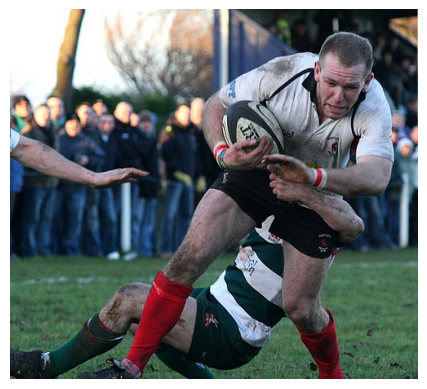

In [100]:
query_text_example = 'Several female lacrosse players are going after a ball .'

best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()


Запрос: A brown dog is sitting in some long grass .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.651604
1  3142055158_01b9e4caa4.jpg    0.621270
2  3044359043_627488ddf0.jpg    0.560990
3  2986716822_e220754d32.jpg    0.529682
4   123997871_6a9ca987b1.jpg    0.496722
5  1429546659_44cb09cbe2.jpg    0.463392
6   989754491_7e53fb4586.jpg    0.456623
7  3122579598_14841c038a.jpg    0.456223
8  3517023411_a8fbd15230.jpg    0.434183
9  3247693965_845b3b4349.jpg    0.428772


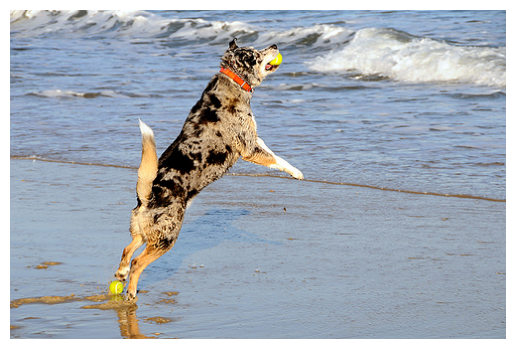

In [101]:
query_text_example = df_test_queries['query_text'].iloc[3]  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A brown dog sits still on a hillside .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.758447
1  2986716822_e220754d32.jpg    0.734070
2  3044359043_627488ddf0.jpg    0.544567
3  3247693965_845b3b4349.jpg    0.539809
4  3142055158_01b9e4caa4.jpg    0.539803
5   661749711_6f408dad62.jpg    0.530220
6  2709359730_13bca100af.jpg    0.495756
7  3033612929_764d977bd5.jpg    0.488381
8  3122579598_14841c038a.jpg    0.481751
9  3154152744_4e93ec8a62.jpg    0.480261


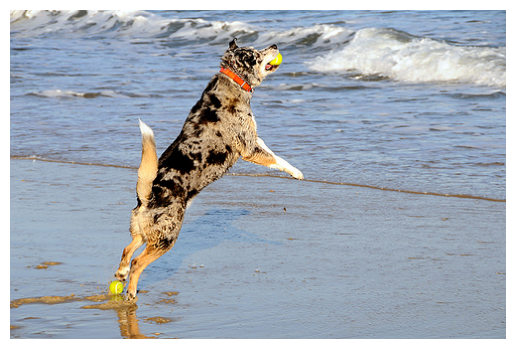

In [102]:
query_text_example = df_test_queries['query_text'].iloc[4]  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A large tan dog sits on a grassy hill .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.665555
1  2986716822_e220754d32.jpg    0.554274
2  3142055158_01b9e4caa4.jpg    0.553621
3  2709359730_13bca100af.jpg    0.475476
4   957682378_46c3b07bcd.jpg    0.443617
5  3488087117_2719647989.jpg    0.441874
6  3122579598_14841c038a.jpg    0.439437
7  3247693965_845b3b4349.jpg    0.424170
8  3517023411_a8fbd15230.jpg    0.417448
9  3154152744_4e93ec8a62.jpg    0.414026


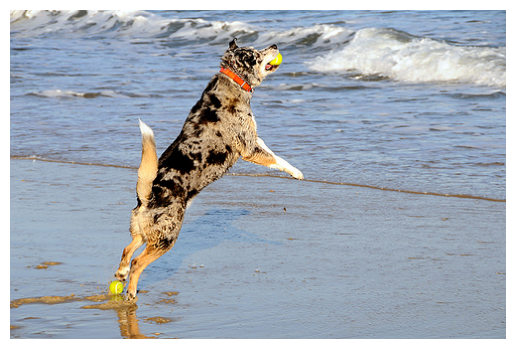

In [103]:
query_text_example = df_test_queries['query_text'].iloc[5]  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A large yellow dog is sitting on a hill .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.625645
1  3142055158_01b9e4caa4.jpg    0.613208
2   123997871_6a9ca987b1.jpg    0.453499
3  3044359043_627488ddf0.jpg    0.450060
4  2986716822_e220754d32.jpg    0.418129
5  3287969199_08e775d896.jpg    0.410012
6  2428094795_d3a8f46046.jpg    0.404815
7  3122579598_14841c038a.jpg    0.399881
8  2709359730_13bca100af.jpg    0.389863
9  3517023411_a8fbd15230.jpg    0.380940


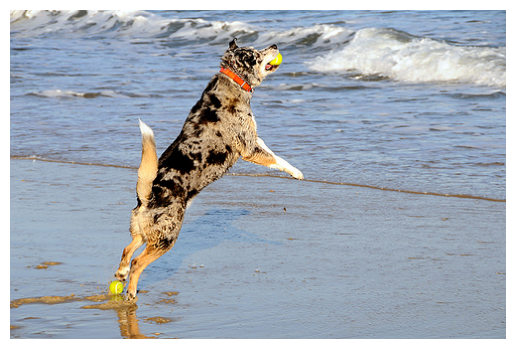

In [104]:
query_text_example = df_test_queries['query_text'].iloc[6]  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: Two dogs stand in the brown grass .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.654851
1  2986716822_e220754d32.jpg    0.555471
2  3142055158_01b9e4caa4.jpg    0.507505
3  3044359043_627488ddf0.jpg    0.433375
4   957682378_46c3b07bcd.jpg    0.426421
5  2709359730_13bca100af.jpg    0.414116
6  3154152744_4e93ec8a62.jpg    0.401490
7  3488087117_2719647989.jpg    0.397624
8  1429546659_44cb09cbe2.jpg    0.390297
9  3287969199_08e775d896.jpg    0.379142


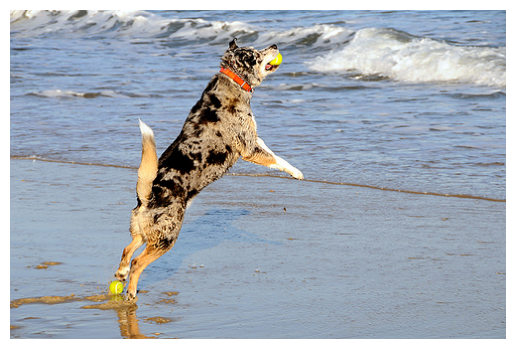

In [105]:
query_text_example = df_test_queries['query_text'].iloc[12]  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A dog jumping off a dock into a pool of water .
Наиболее релевантное изображение: 661749711_6f408dad62.jpg

ТОП-10 изображений:
                  image_name  prediction
0   661749711_6f408dad62.jpg    0.626931
1  2986716822_e220754d32.jpg    0.519539
2   989754491_7e53fb4586.jpg    0.484563
3  3653484549_f316590b0f.jpg    0.447483
4   123997871_6a9ca987b1.jpg    0.411821
5  2141713971_e25eb12712.jpg    0.407724
6  3142055158_01b9e4caa4.jpg    0.407575
7  2399551242_c62a46dd5f.jpg    0.401861
8  3262849619_0bc4f88ef9.jpg    0.398196
9  2517284816_9b8fd3c6b6.jpg    0.396896


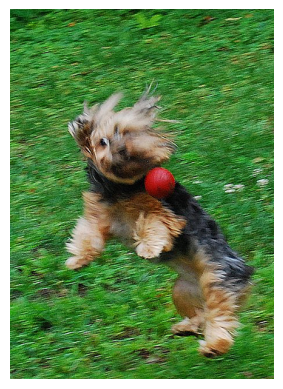

In [106]:
query_text_example = 'A dog jumping off a dock into a pool of water .'  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A group of people in a large yard toss a disc .
Наиболее релевантное изображение: 3142055158_01b9e4caa4.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3142055158_01b9e4caa4.jpg    0.613408
1  3514297698_0512623955.jpg    0.596888
2  3044359043_627488ddf0.jpg    0.532070
3  3122579598_14841c038a.jpg    0.489153
4   123997871_6a9ca987b1.jpg    0.476515
5  2986716822_e220754d32.jpg    0.473744
6  3247693965_845b3b4349.jpg    0.402669
7  2141713971_e25eb12712.jpg    0.387433
8  1429546659_44cb09cbe2.jpg    0.378709
9   634891010_9fa189effb.jpg    0.376453


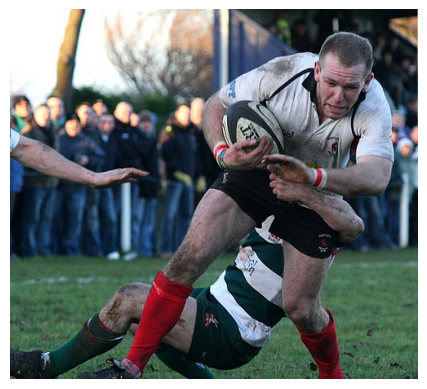

In [107]:
query_text_example = 'A group of people in a large yard toss a disc .'  # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: A caramel colored dog sits in front of trees looking forward .
Наиболее релевантное изображение: 3514297698_0512623955.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3514297698_0512623955.jpg    0.695100
1  3142055158_01b9e4caa4.jpg    0.562753
2  2986716822_e220754d32.jpg    0.561944
3  2709359730_13bca100af.jpg    0.497873
4   957682378_46c3b07bcd.jpg    0.493577
5  3122579598_14841c038a.jpg    0.468471
6  3247693965_845b3b4349.jpg    0.447416
7  3154152744_4e93ec8a62.jpg    0.446497
8  3488087117_2719647989.jpg    0.444330
9  3044359043_627488ddf0.jpg    0.436052


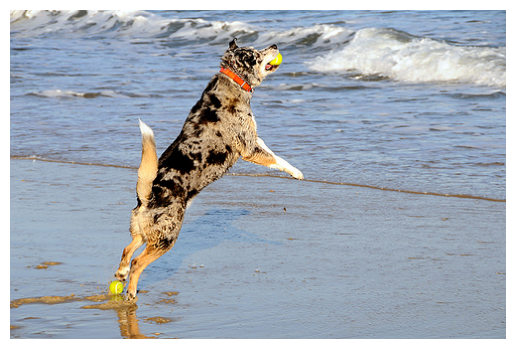

In [108]:
query_text_example = df_test_queries['query_text'].iloc[17] # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Запрос: Two people jump up and down on a cliff overlooking a valley .
Наиболее релевантное изображение: 3142055158_01b9e4caa4.jpg

ТОП-10 изображений:
                  image_name  prediction
0  3142055158_01b9e4caa4.jpg    0.539607
1  3514297698_0512623955.jpg    0.532463
2  3044359043_627488ddf0.jpg    0.406444
3   345785626_9fa59f38ce.jpg    0.390279
4   123997871_6a9ca987b1.jpg    0.377303
5  3287969199_08e775d896.jpg    0.355251
6  3435015880_eda46ff50f.jpg    0.343426
7  3351418768_596ef7fd6f.jpg    0.331521
8  3122579598_14841c038a.jpg    0.317532
9  2517284816_9b8fd3c6b6.jpg    0.314891


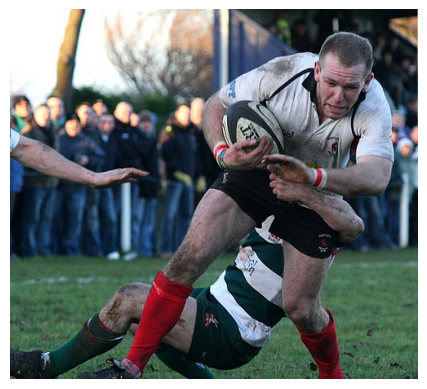

In [109]:
query_text_example = 'Two people jump up and down on a cliff overlooking a valley .' # Берём  текст из датафрейма

# Поиск наиболее релевантного изображения
best_image, top_10_df = find_most_relevant_image_by_text(
    query_text=query_text_example,
    df_test_queries=df_test_queries,
    test_query_embeddings=test_query_embeddings,
    test_image_embeddings=test_embeddings.numpy(),
    test_image_names=test_file_names,
    final_model=final_model,
    device=device
)

# Вывод результата
print(f"Запрос: {query_text_example}")
print(f"Наиболее релевантное изображение: {best_image}")
print("\nТОП-10 изображений:")
print(top_10_df)

# Визуализация наиболее релевантного изображения
from PIL import Image
import os
image_path = os.path.join("test_images", best_image)
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

Итого по разделу:
- из тестового контента удален запрещенный контент
- расчитаны эмбеддинги для текстов и изображений
- создана функция принимающая на вход текстовое описание и выдающая релевантное изображение.
- визуальный анализ релевантности изображения описанию показал очень низкое качество работы модели на тестовых данных. Требуется поднять rmse.

## Итоговые выводы

В ходе проекта реализованы сл. задачи, сформулированы сл. выводы:

1. Проведена загрузка и знакомство с данными

- Проведен анализ оценок экспертов.Значительных отклонений в оценках эспертов не обраружено.
- Оценки экспертов и пользователей краудсорсинга обьеденены и приведены к единому значению.
- Удалены записи с описанием, содержащим запрещенный контент.
Наблюдаем также неуникальность ключей image и query_id. Объединения датафреймов проводились по сумме ключей+

2. Проведен исследовательский анализ  данных 

- Проведен анализ оценок экспертов.Значительных отклонений в оценках эспертов не обраружено.
- Оценки экспертов и пользователей краудсорсинга обьеденены и приведены к единому значению. 
- Удалены записи с описанием, содержащим запрещенный контент.
- Расчитан финальный скорр учитывающий оценки экспертов (больше доверия) и разметчиков краутсорсинга (меньше доверия).
- Наблюдаем также неуникальность ключей image и query_id. Объединения датафреймов проводились по сумме ключей

3. Проведена векторизация изображений

- Расчитаны эмбеддинги изображений тренировочных данных с использованием предобученной REZNET18 "без головы".
- Эмбеддинги сохранены в файл с ключом image

4. Проведена векторизация текстов

- Расчитаны эмбеддинги текстов тренировочных данных с использованием BERT
- Эмбеддинги сохранены в файл с ключом query_id

5.Проведена подготовка данных к обучению

- Данные подготовлены, вектора текстов и изображений объединены в единый вектор размерностью 1280.
- Данные сохранены с целевым признаком в переменные combined_features и target .

6. Обучение и выбор лучшей модели для решения задачи регрессии

- Определена метрика качества RMSE исходя из постановки задачи
- Обучены 3 модели, LR, RIDGE и полносвязная сеть прямого распространения.
- Метрика RMSE лучшей модели (сеть) на тестовой выборке  0.2882590591907501

7.Тестирование модели на новых данных

- из тестового контента удален запрещенный контент
- расчитаны эмбеддинги для текстов и изображений
- создана функция принимающая на вход текстовое описание и выдающая релевантное изображение.

Вывод: Визуальный анализ релевантности изображения описанию показал очень низкое качество работы модели на тестовых данных.

Определены направления по улучшению проекта. (ниже) 


## Направления по улучшению проекта 

1. Поработать с инициализацией весов сети. Если запускать без инициализации, то метрика "из коробки" выше.
2. Использовать лемматизацию.Возможно это даст прирост к качеству моделию
3. Использовать другие сети для векторизации изображений и текста.
4. Использовать другие модели для решения задач регресии. 